In [89]:
import matplotlib.pyplot as plt
import pandas as pd

In [90]:
nn_res_path = "AI_all_new.csv"
heuristic_res_path = "ExecutionTreeContributedCoverage_all.csv"

In [91]:
nn_df = pd.read_csv(nn_res_path)
heu_df = pd.read_csv(heuristic_res_path)

In [92]:
set(pd.read_csv(nn_res_path)["method"]).symmetric_difference(
    set(pd.read_csv(heuristic_res_path)["method"])
)

{'AudioMixer.Read',
 'BaseConvert',
 'Collections.Viewable.ReactiveEx.AddLifetimed',
 'CommentHelpInfo.GetCommentBlock',
 'Common.Serializer.SyncFixedString',
 'FindAllPairShortestPathsJohnsons',
 'FindCombinationRecurse',
 'FindGCD',
 'FindPermutationRecurse',
 'FindSubsetRecurse',
 'GateArrayBase.ClockCycle',
 'GetMaxBiPartiteMatchingMain',
 'HlslGenerator.CalculateApdDependenciesRecurse',
 'HlslParser.ParseStatement',
 'HlslParser.ParseStruct',
 'HlslTokenizer.GetOperatorToken',
 'MOS6502X`1.State',
 'Microsoft.PowerShell.CommandLineParameterParser.ParseFile',
 'Microsoft.PowerShell.CommandLineParameterParser.ParseHelper',
 'PrimeFactorCount',
 'ShaderStringBuilder.Concat',
 'ShaderStringBuilder.Dispose',
 'Sid.Write',
 'System.Management.Automation.ProxyCommand.GetHelpComments',
 'bucketSort',
 'waysToIncreaseLCSBy1'}

In [93]:
def drop_failed(df: pd.DataFrame) -> int:
    failed = df[(df["coverage"] == -1)].index
    return failed


heu_df = heu_df.drop(drop_failed(heu_df))
nn_df = nn_df.drop(drop_failed(nn_df))

In [94]:
heu_df.describe()

,tests,errors,coverage,total_time_sec
count,195.000000,195.000000,195.000000,195.000000
mean,4.507692,12.282051,84.912821,26.800000
std,8.430657,44.481983,26.308001,45.380136
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,76.000000,0.000000
50%,2.000000,3.000000,100.000000,0.000000
75%,4.000000,7.000000,100.000000,27.500000
max,77.000000,519.000000,100.000000,151.000000


In [95]:
nn_df.describe()

,tests,errors,coverage,total_time_sec
count,184.000000,184.000000,184.000000,184.000000
mean,3.070652,11.423913,82.440217,30.076087
std,4.125147,61.859215,28.675054,44.545362
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,71.000000,0.000000
50%,2.000000,2.000000,100.000000,0.500000
75%,3.000000,4.000000,100.000000,96.000000
max,30.000000,627.000000,100.000000,120.000000


In [96]:
nn_df.head()

,method,tests,errors,coverage,total_time_sec
0,BinarySearch,6,1,100.0,0
1,Switches1,30,0,100.0,54
2,Switches2,7,0,100.0,98
3,Switches3,1,3,10.0,96
4,Switches4,10,3,100.0,96


In [97]:
heu_df.head()

,method,tests,errors,coverage,total_time_sec,timeouted
0,BinarySearch,7,1,100.0,0,False
1,Switches1,30,0,100.0,3,False
2,Switches2,12,0,100.0,97,False
3,Switches3,24,3,94.0,120,True
4,Switches4,12,3,100.0,0,False


In [98]:
inner_df = heu_df.merge(nn_df, on="method", how="inner", suffixes=("ETCC", "AI"))
inner_df

,method,testsETCC,errorsETCC,coverageETCC,total_time_secETCC,timeouted,testsAI,errorsAI,coverageAI,total_time_secAI
0,BinarySearch,7,1,100.0,0,False,6,1,100.0,0
1,Switches1,30,0,100.0,3,False,30,0,100.0,54
2,Switches2,12,0,100.0,97,False,7,0,100.0,98
3,Switches3,24,3,94.0,120,True,1,3,10.0,96
4,Switches4,12,3,100.0,0,False,10,3,100.0,96
...,...,...,...,...,...,...,...,...,...,...
170,Microsoft.PowerShell.CommandLineParameterParse...,4,1,100.0,0,False,4,1,100.0,0
171,Microsoft.PowerShell.CommandLineParameterParse...,2,1,100.0,0,False,1,1,100.0,0
172,Microsoft.PowerShell.CommandLineParameterParse...,2,5,100.0,1,False,2,3,100.0,96
173,Microsoft.PowerShell.CommandLineParameterParse...,6,3,100.0,23,False,5,3,100.0,104


In [99]:
def cutoff_by_quantile(df: pd.Series, lower: float = None, upper: float = None):
    lower_df, upper_df = None, None
    if lower is not None:
        lower_df = df[df <= df.quantile(lower, method="table", interpolation="nearest")]
        df = df[df > df.quantile(lower, method="table", interpolation="nearest")]

    if upper is not None:
        upper_df = df[df >= df.quantile(upper, method="table", interpolation="nearest")]
        df = df[df < df.quantile(upper, method="table", interpolation="nearest")]

    return lower_df, df, upper_df

In [100]:
root = "report"

open(root + "/data.txt", "w").close()
with open(root + "/data.txt", "a") as file:
    file.write(",len(AI_more), len(VSharp_more), len(eq)\n")

def compare(
    dataframe: pd.DataFrame,
    on: str,
    desc: str,
    metric: str,
    divider_line: bool = False,
    less_is_winning: bool = False,
    logscale: bool = False,
    exp_name: str = None,
):
    AI_more = dataframe.loc[dataframe[f"{on}ETCC"] < dataframe[f"{on}AI"]]
    VSharp_more = dataframe.loc[dataframe[f"{on}ETCC"] > dataframe[f"{on}AI"]]
    eq = dataframe.loc[dataframe[f"{on}ETCC"] == dataframe[f"{on}AI"]]

    len(AI_more)
    len(VSharp_more)
    len(eq)
    print(exp_name)
    print(f"{len(AI_more)=}, {len(VSharp_more)=}, {len(eq)=}")

    if logscale:
        plt.xscale("log")
        plt.yscale("log")
        desc += ", logscale"

    if divider_line:
        plt.axline([0, 0], [1, 1])

    colors = ["green", "red", "black"]
    if less_is_winning:
        colors = ["red", "green", "black"]

    with open(root + "/data.txt", "a") as file:
        file.write(exp_name + ",")
        file.write(f"{len(AI_more)}, {len(VSharp_more)}, {len(eq)}\n")

    plt.scatter(AI_more[f"{on}ETCC"], AI_more[f"{on}AI"], color=colors[0])
    plt.scatter(VSharp_more[f"{on}ETCC"], VSharp_more[f"{on}AI"], color=colors[1])
    plt.scatter(eq[f"{on}ETCC"], eq[f"{on}AI"], color=colors[2])
    plt.xlabel(f"ETCC {on}, {metric}\n\n{on} comparison on the same methods\n{desc}")
    plt.ylabel(f"AI {on}, {metric}")
    savename = f"{on}.pdf" if exp_name is None else f"{exp_name}.pdf"
    plt.savefig(root + "/" + savename, format="pdf", bbox_inches="tight")
    plt.show()

coverage
len(AI_more)=7, len(VSharp_more)=23, len(eq)=145


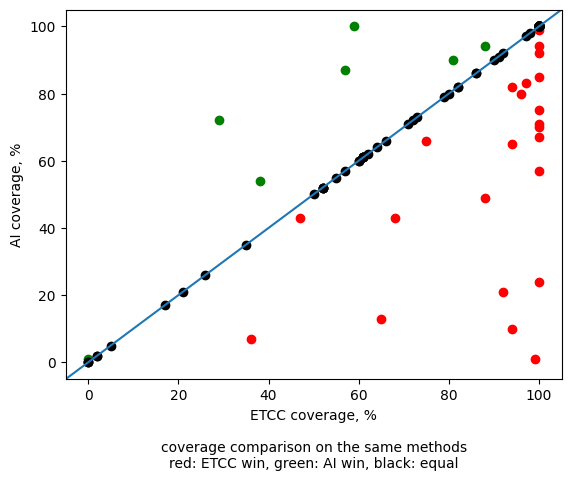

tests
len(AI_more)=15, len(VSharp_more)=60, len(eq)=100


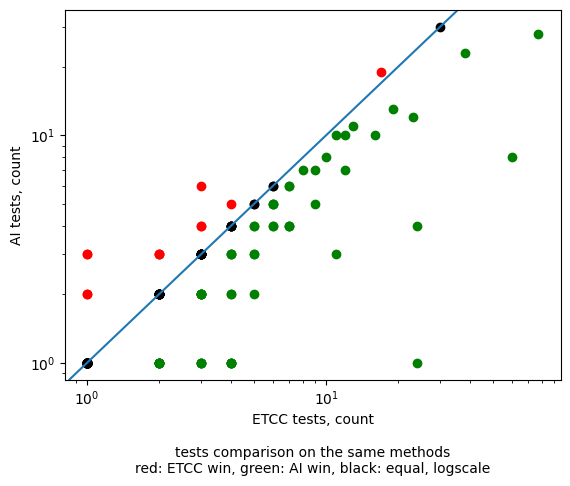

errors
len(AI_more)=13, len(VSharp_more)=52, len(eq)=110


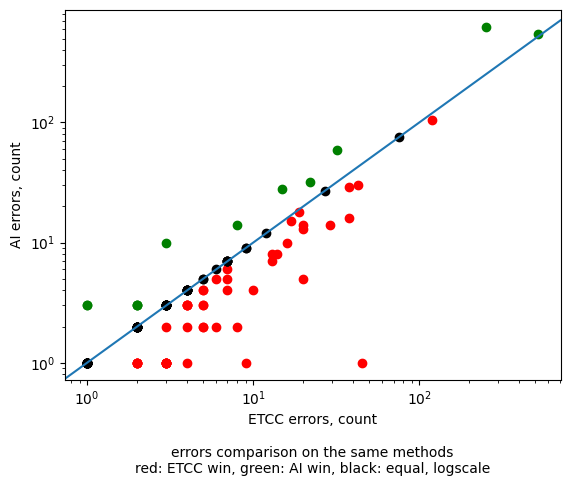

total_time_secs
len(AI_more)=60, len(VSharp_more)=25, len(eq)=90


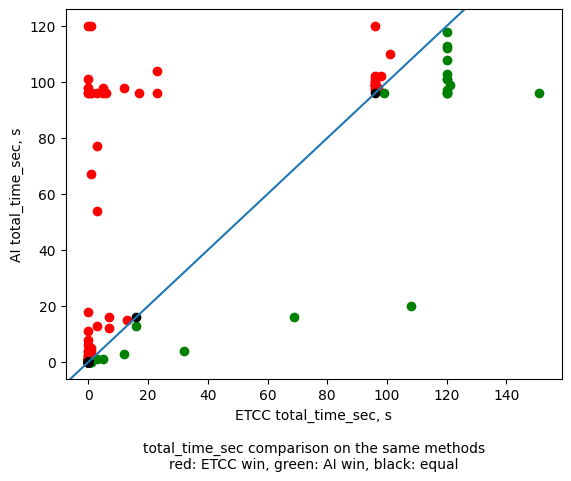

In [101]:
compare(
    dataframe=inner_df,
    on="coverage",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="%",
    divider_line=True,
    exp_name="coverage",
)
compare(
    dataframe=inner_df,
    on="tests",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    less_is_winning=True,
    logscale=True,
    exp_name="tests",
)
compare(
    dataframe=inner_df,
    on="errors",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    logscale=True,
    exp_name="errors",
)
compare(
    dataframe=inner_df,
    on="total_time_sec",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="s",
    divider_line=True,
    less_is_winning=True,
    exp_name="total_time_secs",
)

In [102]:
inner_coverage_eq = inner_df.loc[inner_df["coverageAI"] == inner_df["coverageETCC"]]
# inner_hundred = inner_hundred.loc[inner_hundred["coverageETCC"] == 100]
inner_coverage_eq

,method,testsETCC,errorsETCC,coverageETCC,total_time_secETCC,timeouted,testsAI,errorsAI,coverageAI,total_time_secAI
0,BinarySearch,7,1,100.0,0,False,6,1,100.0,0
1,Switches1,30,0,100.0,3,False,30,0,100.0,54
2,Switches2,12,0,100.0,97,False,7,0,100.0,98
4,Switches4,12,3,100.0,0,False,10,3,100.0,96
5,Switches5,5,5,100.0,0,False,3,2,100.0,1
...,...,...,...,...,...,...,...,...,...,...
170,Microsoft.PowerShell.CommandLineParameterParse...,4,1,100.0,0,False,4,1,100.0,0
171,Microsoft.PowerShell.CommandLineParameterParse...,2,1,100.0,0,False,1,1,100.0,0
172,Microsoft.PowerShell.CommandLineParameterParse...,2,5,100.0,1,False,2,3,100.0,96
173,Microsoft.PowerShell.CommandLineParameterParse...,6,3,100.0,23,False,5,3,100.0,104


tests_eq_coverage
len(AI_more)=12, len(VSharp_more)=37, len(eq)=96


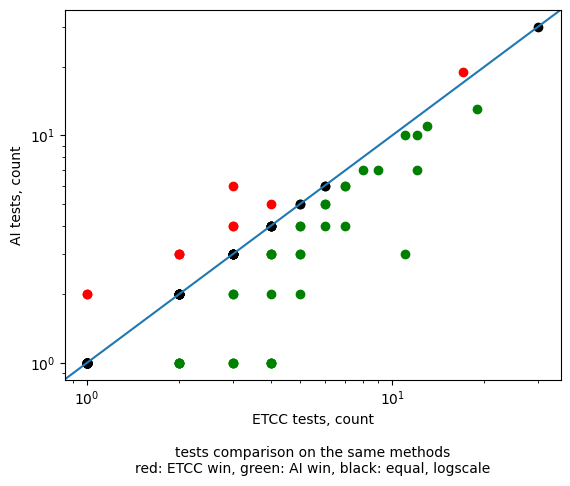

errors_eq_coverage
len(AI_more)=8, len(VSharp_more)=40, len(eq)=97


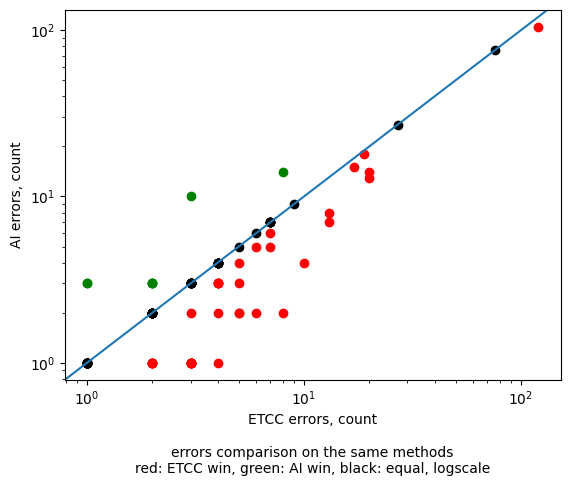

total_time_eq_coverage
len(AI_more)=39, len(VSharp_more)=16, len(eq)=90


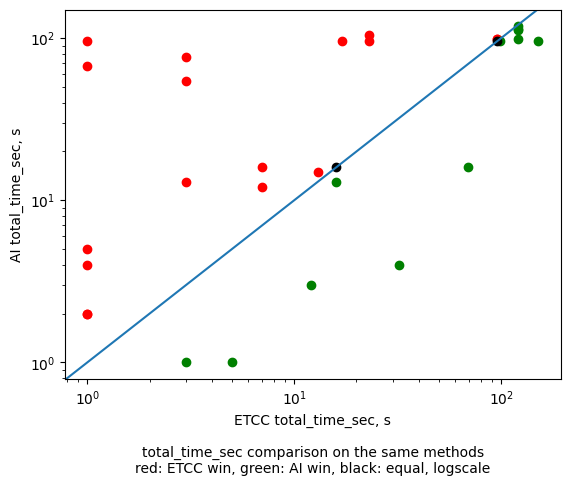

In [103]:
compare(
    dataframe=inner_coverage_eq,
    on="tests",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    less_is_winning=True,
    logscale=True,
    exp_name="tests_eq_coverage"
)
compare(
    dataframe=inner_coverage_eq,
    on="errors",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="count",
    divider_line=True,
    logscale=True,
    exp_name="errors_eq_coverage"
)
compare(
    dataframe=inner_coverage_eq,
    on="total_time_sec",
    desc="red: ETCC win, green: AI win, black: equal",
    metric="s",
    divider_line=True,
    less_is_winning=True,
    logscale=True,
    exp_name="total_time_eq_coverage"
)